In [27]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from os.path import join
from glob import glob
from matplotlib import pyplot as plt
from MDAnalysis import transformations
from decimal import Decimal

from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors
import seaborn as sns

from itertools import islice
import glob
import shutil
import subprocess

In [28]:
def label_pair(bim):
    line=bim
    Type = line.split("/")
    x = Type[8]
    y = x.split("pair")
    u = y[1]
    #y=Type[8]
    #return(x,y)
    return(u)
    
    #y=Type[8]
    #return(x,y)

In [29]:
def label_log(bim):
    line=bim
    Type = line.split("/")
    x = Type[9]
    y = x.split(".")
    y = y[0]
    u=y.split("_")
    u=u[1]
    #y=Type[8]
    #return(x,y)
    return(u)

# Processing Mutated PE

The following script extracts the time and PE from the mutated full length trajectory (untampered xtc file and tpr file)

In [30]:
## This is the path to the first derived trajectory before the trjconv -sep command (og. SP1-SP2 conformation)
path_u1= ('//ptmp/adlouet/alchem/running_lambda/ASASA/A_SP1_A_SP2_A/pair*')
filenames_time_u1=glob.glob(path_u1+'/md_*')
#filenames_time_u1

In [31]:
path_u2= ('//ptmp/adlouet/alchem/running_lambda/ASASA/A_SP2_A_SP1_A/pair*')
filenames_time_u2=glob.glob(path_u2+'/md_*')
#filenames_time_u2

In [19]:
def parsing_u1(path):
    new_PE=[]
    new_md=[]
    new_ts=[]
    for f in path:
        outfile = open(f,'r')
        data = outfile.readlines()
        outfile.close()

        line = subprocess.check_output(['tail', '-1', f])
        time_line = line
        log_number=label_log(str(f))
        pair_number=label_pair(str(f))
        oper=[]
        for index, line in enumerate(data):
            if "Potential    Kinetic En." in line:
                PE=("".join(data[index + 1]))
                PE_word = PE.split()
                potenital_energy=(PE_word[0]) 
                oper.append(potenital_energy)

        save=oper.pop()

        new_PE.append(oper)
        new_PE.append(log_number)        
        new_PE.append(pair_number)
        
    data=[new_PE[i:i+3] for i in range(0, len(new_PE), 3)]
    new_df = pd.DataFrame(data=data)
    new_df.columns=['PE1','md','ts']
    new_df[['PE_0','PE_0.5']] = pd.DataFrame(new_df.PE1.tolist(), index= new_df.index)
    df=new_df.drop(columns=['PE1'])
    df_final = df.sort_values(['ts', 'md'],key=lambda val: val.astype('float64'))
    df_final.replace(to_replace=[None], value=0, inplace=True)
    df_final['PE_0.5'] = df_final['PE_0.5'].astype('float')
    df_final['PE_0'] = df_final['PE_0'].astype('float')
    df_final['delta_PE']=(df_final['PE_0.5'])-(df_final['PE_0'])
    df_final['delta_PE'] = np.where(df_final['PE_0.5'] == 0, '0.0', df_final['delta_PE'])
    df_final['delta_PE'] = df_final['delta_PE'].astype('float')
    df2=df_final.groupby('ts')['delta_PE'].sum()    
    return(df2)

In [20]:
def parsing_u2(path):
    new_PE=[]
    new_md=[]
    new_ts=[]
    for f in path:
        outfile = open(f,'r')
        data = outfile.readlines()
        outfile.close()

        line = subprocess.check_output(['tail', '-1', f])
        time_line = line
        log_number=label_log(str(f))
        pair_number=label_pair(str(f))
        oper=[]
        for index, line in enumerate(data):
            if "Potential    Kinetic En." in line:
                PE=("".join(data[index + 1]))
                PE_word = PE.split()
                potenital_energy=(PE_word[0]) 
                oper.append(potenital_energy)

        save=oper.pop()

        new_PE.append(oper)
        new_PE.append(log_number)        
        new_PE.append(pair_number)
        
    data=[new_PE[i:i+3] for i in range(0, len(new_PE), 3)]
    new_df = pd.DataFrame(data=data)
    new_df.columns=['PE1','md','ts']
    new_df[['PE_0','PE_0.5']] = pd.DataFrame(new_df.PE1.tolist(), index= new_df.index)
    df=new_df.drop(columns=['PE1'])
    df_final = df.sort_values(['ts', 'md'],key=lambda val: val.astype('float64'))
    df_final.replace(to_replace=[None], value=0, inplace=True)
    df_final['PE_0.5'] = df_final['PE_0.5'].astype('float')
    df_final['PE_0'] = df_final['PE_0'].astype('float')
    
    ### This is where the code differs to keep the 
    df_final['delta_PE']=(df_final['PE_0'])-(df_final['PE_0.5'])
    ###
    df_final['delta_PE'] = np.where(df_final['PE_0.5'] == 0, '0.0', df_final['delta_PE'])
    df_final['delta_PE'] = df_final['delta_PE'].astype('float')
    df2=df_final.groupby('ts')['delta_PE'].sum()    
    return(df2)

In [21]:
u1=parsing_u1(filenames_time_u1)
u2=parsing_u2(filenames_time_u2)

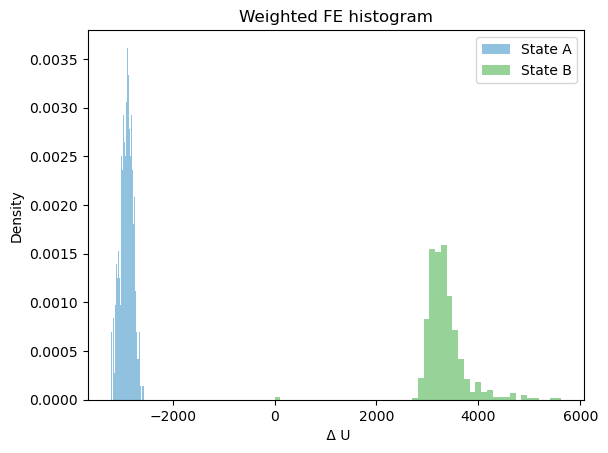

In [22]:
B = plt.hist(u1, 50, density=True, facecolor='#6baed6', alpha=0.75, label='State A')
A = plt.hist(u2, 50, density=True, facecolor='#74c476', alpha=0.75,label='State B')
#ax.legend(loc=1)
plt.ylabel('Density')
plt.xlabel(' \u0394 U')
plt.title('Weighted FE histogram')
plt.legend()

In [23]:
df_A = pd.DataFrame({'U':A[1]})
df_A2=pd.DataFrame({'pU':A[0]})
frames_A = [df_A,df_A2]
result_A = pd.concat(frames_A,axis=1, join="inner")

In [24]:
df_B = pd.DataFrame({'U':B[1]})
df_B2=pd.DataFrame({'pU':B[0]})
frames_B = [df_B,df_B2]
result_B = pd.concat(frames_B,axis=1, join="inner")

In [25]:
from numpy import log as ln
kBT=2.5 #at 298 K

In [26]:
# tot=[]
# #for u in state_A_df['Delta_PE']:
# for u in range(0,3000):
#     lam=[]
#     lam2=[]
#     for x,y in zip(state_A_df['Delta_PE'],state_B_df['Delta_PE']):
#         #lam= 1/1+(exp((-1/KBT)*(x-G1)))
#         lam_a= ln(1/(1+(exp((-1/KT)*(x-u)))))
#         lam_b= ln(1/(1+(exp((-1/KT)*(y-u)))))
#         lam.append(lam_a)
#         lam2.append(lam_b)

#     lam1=sum(lam)
#     lam2=sum(lam2)
#     Total=(lam1+lam2)
#     tot.append(Total)

NameError: name 'state_A_df' is not defined